# Anomaly Detection: The Local Outlier Factor (LOF) Model

## Introductory Remarks

Anomalies are data points that are different from other observations in some way, typically measured against a model fit to the data. On the contrary with the ordinary descriptive statistics, we are interested here to found where these anomalous data points exist and not exclude them as outliers.

We assume the anomaly detection task is unsupervised, i.e. we don’t have training data with points labeled as anomalous. Each data point passed to an anomaly detection model is given a score indicating how different the point is relative to the rest of the dataset. The calculation of this score varies between models, but a higher score always indicates a point is more anomalous. Often a threshold is chosen to make a final classification of each point as typical or anomalous; this post-processing step is left to the user.

The **GraphLab Create (GLC) Anomaly Detection toolkit** currently includes three models for two different data contexts: 

* **Local Outlier Factor**, for detecting outliers in multivariate data that are assumed to be independently and identically distributed,
* **Moving Z-score**, for scoring outliers in a univariate, sequential dataset, typically a time series, and
* **Bayesian Changepoints** for identifying changes in the mean or variance of a sequential series.

In this short note, we demonstrate how the **GLC Local Outlier Factor** Model can be used to *reveal anomalies* in a *multivariate data set*. We will use the customer data from a recent [**AirBnB New User Bookings competition**](https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings) on Kaggle. More specifically, we have downloaded a copy of the file **`train_users_2.csv`** in our working directory. Each row in this dataset describes one of 213,451 AirBnB users; there is a mix of basic features, such as **`gender`**, **`age`**, and **`preferred language`**, as well as the **user's "technology profile"**, including the **browser type**, **device type**, and **his/her sign-up method**.

## Libraries and Necessary Data Transformation

First, we fire up **GraphLab Create**, all the other necessary libraries for our study, and load the **`train_users_2.csv`** file in a **SFrame**.

In [1]:
import graphlab as gl
from visualization_helper_functions import *

[INFO] graphlab.cython.cy_server: GraphLab Create v1.10.1 started. Logging: /tmp/graphlab_server_1466532393.log
INFO:graphlab.cython.cy_server:GraphLab Create v1.10.1 started. Logging: /tmp/graphlab_server_1466532393.log


This non-commercial license of GraphLab Create is assigned to tgrammat@gmail.com and will expire on September 21, 2016. For commercial licensing options, visit https://dato.com/buy/.


In [2]:
customer_data = gl.SFrame.read_csv('./train_users_2.csv')

Finished parsing file /home/theod/Documents/ML_Home/12.DatoPy/01.R.Anomaly_Detection/train_users_2.csv

Parsing completed. Parsed 100 lines in 4.11956 secs.

Finished parsing file /home/theod/Documents/ML_Home/12.DatoPy/01.R.Anomaly_Detection/train_users_2.csv

Parsing completed. Parsed 213451 lines in 2.96087 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,int,str,str,float,str,int,str,str,str,str,str,str,str,str]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


In [3]:
customer_data.head(5)

Columns:
	id	str
	date_account_created	str
	timestamp_first_active	int
	date_first_booking	str
	gender	str
	age	float
	signup_method	str
	signup_flow	int
	language	str
	affiliate_channel	str
	affiliate_provider	str
	first_affiliate_tracked	str
	signup_app	str
	first_device_type	str
	first_browser	str
	country_destination	str

Rows: 5

Data:
+------------+----------------------+------------------------+--------------------+
|     id     | date_account_created | timestamp_first_active | date_first_booking |
+------------+----------------------+------------------------+--------------------+
| gxn3p5htnn |      2010-06-28      |     20090319043255     |                    |
| 820tgsjxq7 |      2011-05-25      |     20090523174809     |                    |
| 4ft3gnwmtx |      2010-09-28      |     20090609231247     |     2010-08-02     |
| bjjt8pjhuk |      2011-12-05      |     20091031060129     |     2012-09-08     |
| 87mebub9p4 |      2010-09-14      |     20091208061105     |     2010-02-18     |
+------------+----------------------+------------------------+--------------------+
+-----------+------+---------------+-------------+----------+-------------------+
|   gender  | age  | signup_method | signup_flow | language | affiliate_channel |
+-----------+------+---------------+-------------+----------+-------------------+
| -unknown- | None |    facebook   |      0      |    en    |       direct      |
|    MALE   | 38.0 |    facebook   |      0      |    en    |        seo        |
|   FEMALE  | 56.0 |     basic     |      3      |    en    |       direct      |
|   FEMALE  | 42.0 |    facebook   |      0      |    en    |       direct      |
| -unknown- | 41.0 |     basic     |      0      |    en    |       direct      |
+-----------+------+---------------+-------------+----------+-------------------+
+--------------------+-------------------------+------------+-------------------+
| affiliate_provider | first_affiliate_tracked | signup_app | first_device_type |
+--------------------+-------------------------+------------+-------------------+
|       direct       |        untracked        |    Web     |    Mac Desktop    |
|       google       |        untracked        |    Web     |    Mac Desktop    |
|       direct       |        untracked        |    Web     |  Windows Desktop  |
|       direct       |        untracked        |    Web     |    Mac Desktop    |
|       direct       |        untracked        |    Web     |    Mac Desktop    |
+--------------------+-------------------------+------------+-------------------+
+---------------+---------------------+
| first_browser | country_destination |
+---------------+---------------------+
|     Chrome    |         NDF         |
|     Chrome    |         NDF         |
|       IE      |          US         |
|    Firefox    |        other        |
|     Chrome    |          US         |
+---------------+---------------------+
[5 rows x 16 columns]

For the needs of our current presentation we will only need a small subset of the available basic customer features, i.e. **`'gender'`**, **`'age'`** and **`'language'`**.

In [4]:
features = ['gender', 'age', 'language']
customer_data = customer_data[['id']+features]
customer_data

id,gender,age,language
gxn3p5htnn,-unknown-,None,en
820tgsjxq7,MALE,38.0,en
4ft3gnwmtx,FEMALE,56.0,en
bjjt8pjhuk,FEMALE,42.0,en
87mebub9p4,-unknown-,41.0,en
osr2jwljor,-unknown-,None,en
lsw9q7uk0j,FEMALE,46.0,en
0d01nltbrs,FEMALE,47.0,en
a1vcnhxeij,FEMALE,50.0,en
6uh8zyj2gn,-unknown-,46.0,en


From the quick exploratory data analysis below:

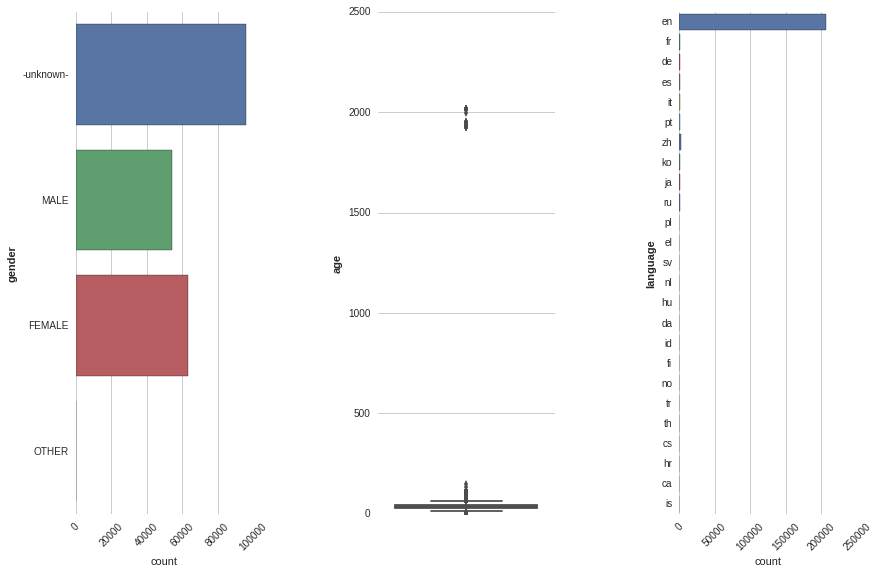


Summary Statistics:

           gender            age language
count      213451  125461.000000   213451
unique          4            NaN       25
top     -unknown-            NaN       en
freq        95688            NaN   206314
mean          NaN      49.668335      NaN
std           NaN     155.666612      NaN
min           NaN       1.000000      NaN
25%           NaN      28.000000      NaN
50%           NaN      34.000000      NaN
75%           NaN      43.000000      NaN
max           NaN    2014.000000      NaN


In [5]:
%matplotlib inline
univariate_summary_plot(customer_data, features, nsubplots_inrow=3, subplots_wspace=0.7)

In [6]:
gl.canvas.set_target('browser')
customer_data[['age']].show()

Canvas is accessible via web browser at the URL: http://localhost:34510/index.html
Opening Canvas in default web browser.


In [7]:
print 'Number of customer records with ages larger than 2013: %d' %\
len(customer_data[customer_data['age'] >= 2013])

Number of customer records with ages larger than 2013: 749


we notice that there about 750 records having an **`'age'`** value of `'2013'` or `'2014'`, which is of course wrong. Most probably the year was recorded accidentally in this field.  The remaining **`'age'`** values seams absolutely reasonable with only some rare customer entries that have ages greater than `'100'`. In fact more than 128 thousand customer entries are found to have ages in the `[1, 142]` interval. More specifically, we have choosen to assume any value falling in the `[1,150]` interval as an elligible recording of a customer age, re-assigning all the remaining ones as `missing`:

In [8]:
customer_data['age'] = customer_data['age'].apply(lambda age: age if age < 150 else None)
customer_data = customer_data.dropna(columns = features, how='any')
print 'Number of Rows in dataset: %d' % len(customer_data)

Number of Rows in dataset: 124681


Now, the univariate summary statistics of the **`customer_data`** set takes the form:

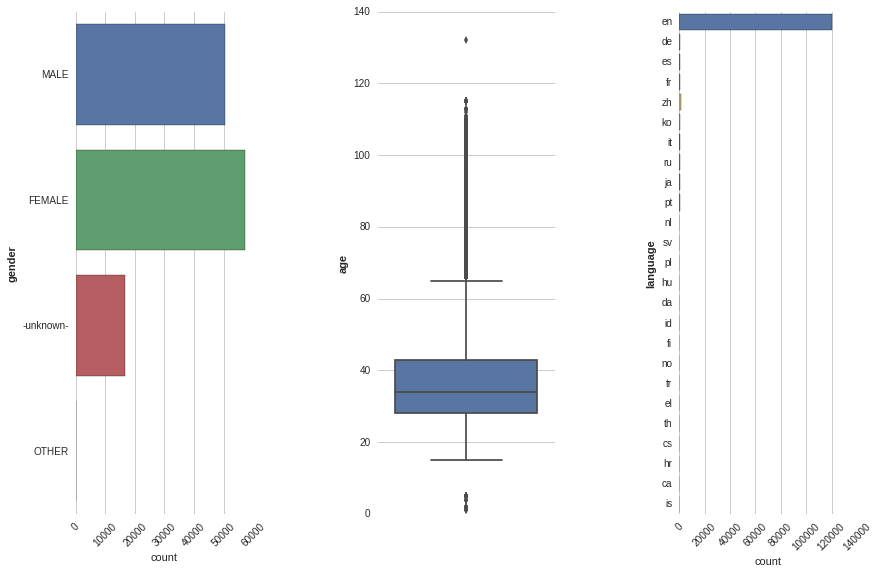


Summary Statistics:

        gender            age language
count   124681  124681.000000   124681
unique       4            NaN       25
top     FEMALE            NaN       en
freq     57247            NaN   120173
mean       NaN      37.412629      NaN
std        NaN      13.954917      NaN
min        NaN       1.000000      NaN
25%        NaN      28.000000      NaN
50%        NaN      34.000000      NaN
75%        NaN      43.000000      NaN
max        NaN     132.000000      NaN


In [9]:
univariate_summary_plot(customer_data, features, nsubplots_inrow=3, subplots_wspace=0.7)

and more specifically the remaining **customer ages** follow the distribution below:

In [10]:
# transform the SFrame into a Pandas DataFrame
customer_data_df = customer_data.to_dataframe()
customer_data_df['gender'] = customer_data_df['gender'].astype(str)
customer_data_df['age'] = customer_data_df['age'].astype(float)
customer_data_df['language'] = customer_data_df['language'].astype(str)

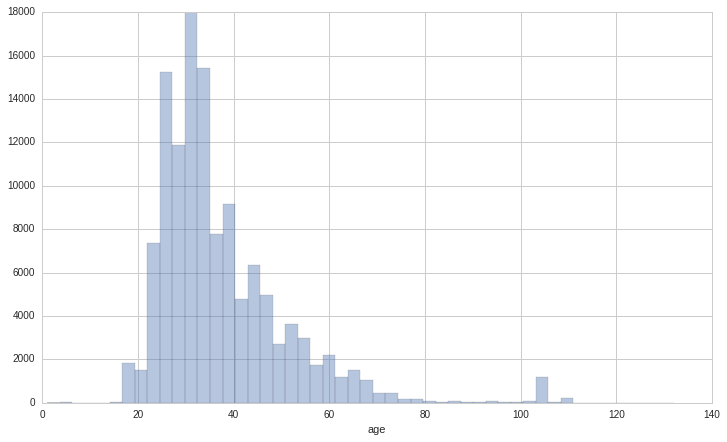

In [12]:
# define seaborn style, palette, color codes
sns.set(style="whitegrid", palette="deep",color_codes=True)
# initialize the matplotlib figure
plt.figure(figsize=(12,7))

# draw distplot
ax1 = sns.distplot(customer_data_df.age, bins=None, hist=True, kde=False, rug=False, color='b')

If we would like to explore in more detail the countplot for the variable **`language`**, we can temporarily exclude the **english-speaking customers** and redraw the graph:

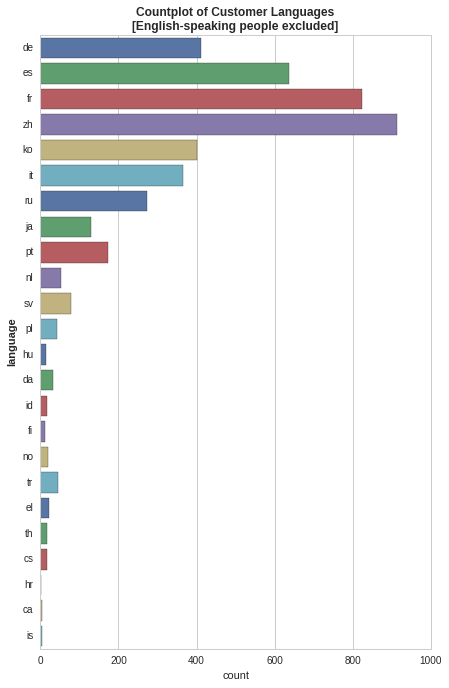

In [13]:
# exclude the english-speaking customers
customer_data_df_nen = customer_data_df[customer_data_df['language']!='en']

# define seaborn style, palette, color codes
sns.set(style="whitegrid", palette="deep",color_codes=False)
# initialize the matplotlib figure
plt.figure(figsize=(7,11))
plt.ylabel('language', {'fontweight': 'bold'})
plt.title('Countplot of Customer Languages\n[English-speaking people excluded]',
          {'fontweight': 'bold'})

# draw countplot
ax2 = sns.countplot(y='language', data=customer_data_df_nen, palette='deep', color='b')

The univariate summary statistics plot for this new **`customer_data_df_nen`** set is as follows.

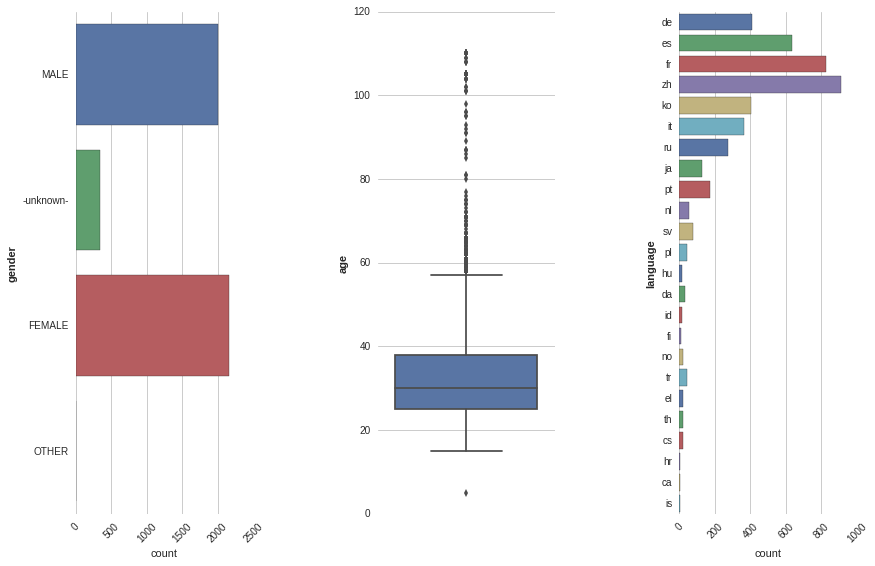


Summary Statistics:

        gender          age language
count     4508  4508.000000     4508
unique       4          NaN       24
top     FEMALE          NaN       zh
freq      2152          NaN      912
mean       NaN    33.222050      NaN
std        NaN    13.060345      NaN
min        NaN     5.000000      NaN
25%        NaN    25.000000      NaN
50%        NaN    30.000000      NaN
75%        NaN    38.000000      NaN
max        NaN   110.000000      NaN


In [14]:
univariate_summary_plot(customer_data_df_nen, features, subplots_wspace=0.7)

The data set of interest, **customer_data**, has two nominal categorical variables:

* **`'gender'`:** nominal categorical attribute (`FEMALE/MALE/unknown/OTHER`)
* **`'language'`:** nominal categorical attribute of 25 different languages.

which we should better encode them prior of applying any learning algorithm. To do so we will apply the **OneHotEncoding transformation** as shown below:

In [15]:
one_hot_encoder = gl.toolkits.feature_engineering.OneHotEncoder(features=['gender', 'language'])
customer_data1 = one_hot_encoder.fit_transform(customer_data)

**Local Outlier Factor (LOF) Models** are *distance-based learning algorithms*. Therefore, we need to standardize the **`'age'`** feature in order to be on roughly the same scale as the encoded categorical variables.

In [16]:
customer_data1['age'] = (customer_data['age'] - customer_data['age'].mean())/\
customer_data['age'].std()
customer_data1

id,age,encoded_features
820tgsjxq7,0.0420907775098,"{2: 1, 28: 1}"
4ft3gnwmtx,1.33196384402,"{3: 1, 28: 1}"
bjjt8pjhuk,0.328729236733,"{3: 1, 28: 1}"
87mebub9p4,0.257069621927,"{1: 1, 28: 1}"
lsw9q7uk0j,0.615367695957,"{3: 1, 28: 1}"
0d01nltbrs,0.687027310763,"{3: 1, 28: 1}"
a1vcnhxeij,0.90200615518,"{3: 1, 28: 1}"
6uh8zyj2gn,0.615367695957,"{1: 1, 28: 1}"
yuuqmid2rp,-0.101228452102,"{3: 1, 28: 1}"
om1ss59ys8,0.687027310763,"{3: 1, 28: 1}"


## Training a Local Outlier Factor (LOF) Model

Next, we train the **LOF model** by using this transformed **customer_data2** set.

In [17]:
model_lof = gl.anomaly_detection.local_outlier_factor.create(customer_data1, 
                                                             features = ['age', 'encoded_features'],
                                                             threshold_distances=True,
                                                             verbose=False)

In [18]:
model_lof.save('./model_lof')

model_lof = gl.load_model('./model_lof/')

In [19]:
print 'The LOF model has been trained with the following options:'
print '-------------------------------------------------------------'
print model_lof.get_current_options()

The LOF model has been trained with the following options:
-------------------------------------------------------------
{'distance': [[['encoded_features'], 'jaccard', 1.0], [['age'], 'euclidean', 1.0]], 'verbose': False, 'num_neighbors': 5, 'threshold_distances': True}


Note that the model can automatically choose a suitable metric for the data type of the features we have available. Here, a composite distance of a **`'jaccard'`** and **`'euclidean'` metric** has been chosen for the **`'encoded_features'`** and the **`'age'`** columns respectively. Both these two metrics have been weighted with `1.0`. 

If we want what has been built by the model internally we can simply write:

In [20]:
print model_lof

Class                                   : LocalOutlierFactorModel

Schema
------
Number of examples                      : 124681
Number of feature columns               : 2
Number of neighbors                     : 5
Use thresholded distances               : True
Number of distance components           : 2
Row label name                          : row_id

Training summary
----------------
Total training time (seconds)           : 2467.8927

Accessible fields
-----------------
nearest_neighbors_model                 : Model used internally to compute nearest neighbors.
scores                                  : Local outlier factor for each row in the input dataset.


More importantly, here is the **SFrame** with the **LOF anomaly scores**:

In [21]:
model_lof['scores']

row_id,density,anomaly_score,neighborhood_radius
0,inf,nan,0.0
1,inf,nan,0.0
2,inf,nan,0.0
3,inf,nan,0.0
4,inf,nan,0.0
5,inf,nan,0.0
6,inf,nan,0.0
7,inf,nan,0.0
8,inf,nan,0.0
9,inf,nan,0.0


Firstly, note that the model worked successfully, scoring each of the 124,681 input rows. Secondly, the anomaly score for many observations in our **AirBnB dataset** is **`nan`** which indicates the point has many neighbors at exactly the same location, making the ratio of densities undefined. These points cannot be outliers.

However, for the problem at hand we are interested to find if any outliers exist and under what circumstances this happens. This is where the real business value exists!

## Using the LOF Model to detect anomalies

There are two common ways to detect which observations of your data set are anomalous or not:

**A.** Ask from the trained model to return the *k more anomalous observations*:
```
By applying the .topk() method of the model scores SFrame
```

In [22]:
top10_anomalies = model_lof['scores'].topk('anomaly_score', k=10)
top10_anomalies.print_rows(num_rows=10)

+--------+---------------+---------------+---------------------+
| row_id |    density    | anomaly_score | neighborhood_radius |
+--------+---------------+---------------+---------------------+
|  787   | 13.9548615034 |      inf      |   0.0716596148059   |
|  3678  | 13.9548615034 |      inf      |   0.0716596148059   |
|  5328  | 1.63764535897 |      inf      |    0.666666666667   |
|  6528  | 2.09512063742 |      inf      |    0.666666666667   |
|  8788  | 13.9548615034 |      inf      |   0.0716596148059   |
|  9626  | 13.9548615034 |      inf      |   0.0716596148059   |
| 10083  |      1.5      |      inf      |    0.666666666667   |
| 10727  | 13.9548615034 |      inf      |   0.0716596148059   |
| 10765  | 13.9548615034 |      inf      |   0.0716596148059   |
| 11038  |      1.5      |      inf      |    0.666666666667   |
+--------+---------------+---------------+---------------------+
[10 rows x 4 columns]



Note that the anomaly scores for these points are infinite, which happens when a point is next to several identical points, but is not itself a member of that bunch. These points are certainly anomalous, but our specific choice of k was arbitrary and excluded many points that are also likely anomalous.

**B.** Choose a *threshold*, either from domain knowledge or scientific expertise in order to find the anomalous observations in your data set:
```
observations with 'anomaly_score' greater than this 'threshold' will be the anomalous ones.
```
Of course, a closer look at the distribution of the `anomaly_scores` may help us a lot with this decision.

In [23]:
anomaly_scores_sketch = model_lof['scores']['anomaly_score'].sketch_summary()
print anomaly_scores_sketch


+--------------------+--------+----------+
|        item        | value  | is exact |
+--------------------+--------+----------+
|       Length       | 124681 |   Yes    |
|        Min         | 0.865  |   Yes    |
|        Max         |  inf   |   Yes    |
|        Mean        |  nan   |   Yes    |
|        Sum         |  inf   |   Yes    |
|      Variance      |  nan   |   Yes    |
| Standard Deviation |  nan   |   Yes    |
|  # Missing Values  |   0    |   Yes    |
|  # unique values   |  580   |    No    |
+--------------------+--------+----------+

Most frequent items:
+-------+-----+-----+----------------+------+----------------+----------------+
| value | 1.0 | inf | 0.966666666667 | 1.08 | 0.933333333333 | 0.942857142857 |
+-------+-----+-----+----------------+------+----------------+----------------+
| count | 643 | 193 |       29       |  26  |       19       |       18       |
+-------+-----+-----+----------------+------+----------------+----------------+
+----------------+

In [24]:
threshold = anomaly_scores_sketch.quantile(0.9)
anomalies_mask = model_lof['scores']['anomaly_score'] >= threshold
anomalies = model_lof['scores'][anomalies_mask]
print 'Threshold: %.5f' % threshold, '\nNumber of Anomalies: %d' % len(anomalies)

Threshold: inf 
Number of Anomalies: 193


In [25]:
anomalies.print_rows(num_rows=10)

+--------+---------------+---------------+---------------------+
| row_id |    density    | anomaly_score | neighborhood_radius |
+--------+---------------+---------------+---------------------+
|  787   | 13.9548615034 |      inf      |   0.0716596148059   |
|  3678  | 13.9548615034 |      inf      |   0.0716596148059   |
|  5328  | 1.63764535897 |      inf      |    0.666666666667   |
|  6528  | 2.09512063742 |      inf      |    0.666666666667   |
|  8788  | 13.9548615034 |      inf      |   0.0716596148059   |
|  9626  | 13.9548615034 |      inf      |   0.0716596148059   |
| 10083  |      1.5      |      inf      |    0.666666666667   |
| 10727  | 13.9548615034 |      inf      |   0.0716596148059   |
| 10765  | 13.9548615034 |      inf      |   0.0716596148059   |
| 11038  |      1.5      |      inf      |    0.666666666667   |
+--------+---------------+---------------+---------------------+
[193 rows x 4 columns]



Finally, we can filter out the **`customer_data`** set by the **`anomalies['row_id']`** to obtain the original features of these anomalous data points in record.

In [26]:
customer_data = customer_data.add_row_number(column_name='row_id')
anomalous_customer_data = customer_data.filter_by(anomalies['row_id'], 'row_id')
anomalous_customer_data.print_rows(num_rows=200)

+--------+------------+-----------+-------+----------+
| row_id |     id     |   gender  |  age  | language |
+--------+------------+-----------+-------+----------+
|  787   | w6i3ix717s |   OTHER   |  36.0 |    en    |
|  3678  | jwzspk0ipl |    MALE   |  39.0 |    zh    |
|  5328  | eqsihtnz34 |   FEMALE  |  36.0 |    hu    |
|  6528  | dyu0sssqo5 | -unknown- |  47.0 |    nl    |
|  8788  | 91vfcvol82 |    MALE   |  91.0 |    en    |
|  9626  | t6fvmrna0t |    MALE   |  98.0 |    en    |
| 10083  | n45ipduv9i |    MALE   |  28.0 |    fi    |
| 10727  | 9zhr7vpciy |    MALE   |  39.0 |    fr    |
| 10765  | lerui8bp4h |   FEMALE  |  88.0 |    en    |
| 11038  | h0cf46ubyt |    MALE   |  27.0 |    fi    |
| 12293  | unnvgq3efo |    MALE   |  40.0 |    pl    |
| 13926  | 1yoqktv6n6 |   OTHER   |  36.0 |    en    |
| 13980  | 2a9z5icq6y |    MALE   |  39.0 |    de    |
| 14044  | oyr9d8w1ig |   OTHER   |  39.0 |    en    |
| 15897  | lqf1twcvos |    MALE   | 101.0 |    en    |
| 17154  |